In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc,roc_curve
import transformers
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,SequentialSampler
import warnings
warnings.filterwarnings('ignore')
#Specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 
'cpu')

In [6]:
#Loading dataset
df = pd.read_csv(r'/content/drive/MyDrive/Kaggle Dataset/spamdata_v2.csv')
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Shape of the Dataset

In [7]:
df.shape

(5572, 2)

Distribution of label

In [8]:
print('{}'.format(round(df['label'].value_counts(normalize=True)*100,2)))

0    86.59
1    13.41
Name: label, dtype: float64


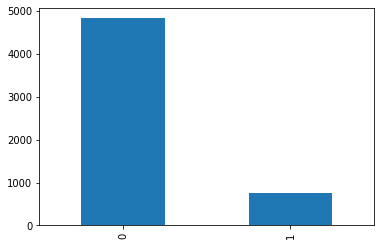

In [9]:
df['label'].value_counts().plot(kind='bar')

From the above plot it is clearly understood there is an imbalance in dataset. Label 1 is spam and label 0 is taken as ham

**Split the dataset into train, validation and test sets**

In [10]:
x_train,temp_x,y_train,temp_y = train_test_split(df['text'],df['label'],
                                                       random_state=42,
                                                       test_size=0.3,stratify=df['label'])

#split the temp_x and temp_y for validation and test
x_val,x_test,y_val,y_test = train_test_split(temp_x,temp_y,test_size=.5,random_state=42,stratify=temp_y)


**Shape of the train, validation and test datasets**

In [11]:
print("Shape of the training dataset : ",x_train.shape,y_train.shape)
print("Shape of the Validation Dataset : ",x_val.shape,y_val.shape)
print("Shape of the Test Dataset : ", x_test.shape, y_test.shape)

Shape of the training dataset :  (3900,) (3900,)
Shape of the Validation Dataset :  (836,) (836,)
Shape of the Test Dataset :  (836,) (836,)


**Preprocess the dataset with Bert Model and Tokenizer**

In [12]:
model = "bert-base-uncased"
bert = AutoModel.from_pretrained(model)
#tokenize the sentences into tokens and into vectors
tokenizer = BertTokenizerFast.from_pretrained(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
#For example take the first 2 sentences in the ds 
sent_vector = tokenizer.batch_encode_plus([x_train[0],x_train[1]], padding=True, return_token_type_ids=False)
print([x_train[0],x_train[1]])
print(sent_vector)

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...']
{'input_ids': [[101, 2175, 2127, 18414, 17583, 2391, 1010, 4689, 1012, 1012, 2800, 2069, 1999, 11829, 2483, 1050, 2307, 2088, 2474, 1041, 28305, 1012, 1012, 1012, 25022, 2638, 2045, 2288, 26297, 28194, 1012, 1012, 1012, 102], [101, 7929, 2474, 2099, 1012, 1012, 1012, 16644, 15536, 2546, 1057, 2006, 2072, 1012, 1012, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


**Check the average sequence length in the train set**

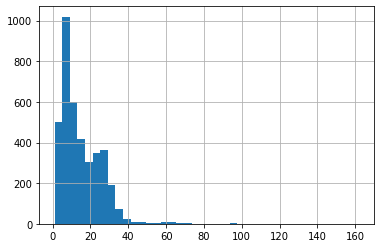

In [14]:
seq_len = [len(i.split()) for i in x_train]
#lets plot a distribution of the length of sentences in train set
pd.Series(seq_len).hist(bins=40)

From the above plot, we can see that most of the sentences have a max length of 25 or less than that, so we set a max_length as 25 for padding.

In [15]:
pad_len = 25

In [16]:
#tokenize and encode the train set
tokens_train = tokenizer.batch_encode_plus(x_train.tolist(),
                                           max_length = pad_len,
                                           pad_to_max_length = True,
                                           truncation = True,
                                           return_token_type_ids = False)

In [17]:
#tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(x_val.tolist(),
                                         max_length = pad_len,
                                         pad_to_max_length = True,
                                         truncation = True,
                                         return_token_type_ids = False)

In [18]:
tokens_test = tokenizer.batch_encode_plus(x_test.tolist(),
                                          max_length = pad_len,
                                          pad_to_max_length = True,
                                          truncation = True,
                                          return_token_type_ids = False)

**Convert the encoded vectors to Tensors**

In [19]:
#train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

In [20]:
#validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

In [21]:
#test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

**Create DataLoaders for train, validation tensors**

In [22]:
#define batch size
batch_size = 32
#train data
#Combine tensors to create our train data
train_data = TensorDataset(train_seq,train_mask,train_y)
#smapler for sampling the data during training
train_sampler = RandomSampler(train_data)
#dataloader for train data
train_dataloader = DataLoader(train_data,
                              sampler =  train_sampler,
                              batch_size = batch_size)

In [23]:
#validation
#Combine tensors
val_data = TensorDataset(val_seq,val_mask,val_y)
#sampler for validation 
val_sampler = SequentialSampler(val_data)
#DataLoader
val_dataloader = DataLoader(val_data,
                            sampler = val_sampler,
                            batch_size = batch_size)

**Define Model Architecture**

In [24]:
#Frezze bert Parameters for fine tuning
for param in bert.parameters():
  param.requires_grad = False

In [25]:
#Model Architecture
class BERT_Arch(nn.Module):
  #initializing the model
  def __init__(self,bert):

    super(BERT_Arch, self).__init__()

    self.bert = bert #bert_base_uncased
    self.dropout = nn.Dropout(0.1) #dropout layer
    self.relu = nn.ReLU() #activation fn for dense layers
    self.fc1 = nn.Linear(768,512) #first fully connected layer layer1
    self.fc2 = nn.Linear(512,2) #second fully connected layer
    self.softmax = nn.LogSoftmax(dim=1) #softmax activation function

  #define the forward propogation
  def forward(self, sent_id, mask ):
    #pass inputs into the model
    _, cls_hs = self.bert(sent_id,attention_mask = mask,return_dict=False)
    #fc1
    fc1_output = self.fc1(cls_hs)
    fc1_act_output = self.relu(fc1_output)
    dropout_output = self.dropout(fc1_act_output)
    #fc2 -->This is the last fc layer and outputs as 0 or 1
    fc2_output = self.fc2(dropout_output)
    #softmax activation for output layer
    final_output = self.softmax(fc2_output)
    return final_output


**Passing the pretrained BERT model to the defined architecture for fine-tuning**

In [26]:
model = BERT_Arch(bert)
#push the model to GPU
model = model.to(device)

In [27]:
#define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-3)

**Find Class Weights**

In [28]:
#Since the dataset is unbalanced, should make aware of the model how to treat the classes in the cost function.
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)


In [29]:
print(class_weights)
#convert class weights list to tensors
weights = torch.tensor(class_weights, dtype= torch.float)
weights = weights.to(device)

[0.57743559 3.72848948]


**Define Loss Function**

In [30]:

cross_entropy = nn.NLLLoss(weight = weights)
#define the no of training epochs
epochs = 15

**Fine-tune the model** <br>
Define a function to train the model

In [31]:
def train():
  model.train()
  loss, accuracy = 0, 0
  preds = []
  #iterate over batches
  for step,batch in enumerate(train_dataloader):
    #print update after every 50 batches
    if step % 50 == 0 and not step == 0:
      print('Batch {:>5,} of {:>5,}'.format(step,len(train_dataloader)))
    batch = [row.to(device) for row in batch ]
    
    sent_id, mask, labels = batch
    #clearing the previous gradients
    model.zero_grad()
    #pred for the current batch
    batch_pred = model(sent_id,mask)
    #calculate loss between labels and batch_pred
    batch_loss = cross_entropy(batch_pred,labels)
    loss = loss + batch_loss.item() #add to loss
    #backpropogation to calculate the gradients
    batch_loss.backward()
    #make the gradient to 1.0 inorder to prevent the gradient exploding problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step() #parameter updation
    #when connection to gpu
    batch_pred = batch_pred.detach().cpu().numpy()
  #appending the model prediction of each batch
  preds.append(batch_pred)
  #compute the avg training loss
  avg_loss = loss / len(train_dataloader)
  #reshaping the predictions in the form of (no:of samples,no:of classes)
  preds = np.concatenate(preds, axis =0)
  return avg_loss, preds


** Define function for evaluating the model through validation dataset**

In [32]:
def validate():
  model.eval() #deactivate the dropout layers
  loss, accuracy = 0, 0
  preds = []

  for step,batch in enumerate(val_dataloader):
    if step%50 == 0 and not step == 0 :
      #elapsed_time = format_time(time.time() - t0)
      print('Batch {:>5,} of {:>5,}'.format(step,len(val_dataloader)))
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    
    #deactivating autograd
    with torch.no_grad():
      batch_pred = model(sent_id,mask)
    #calculate loss between labels and batch_pred
      batch_loss = cross_entropy(batch_pred,labels)
      loss = loss + batch_loss.item() #add to loss
      batch_pred = batch_pred.detach().cpu().numpy()
      preds.append(batch_pred)
  #compute the avg training loss
  avg_loss = loss / len(train_dataloader)

  preds = np.concatenate(preds, axis =0)
  
  return avg_loss, preds

**Train the model**

In [33]:
model_loss = float('inf')
tr_losses = []
val_losses = []

for epoch in range(epochs):
  print("\n Epoch {:} / {:}".format(epoch +1, epochs ))
  #train model
  tr_loss, _ = train()
  #validate model
  val_loss, _ = validate()

  if val_loss < model_loss:
    model_loss = val_loss
    torch.save(model.state_dict(), 'weights.pt')
  
  tr_losses.append(tr_loss)
  val_losses.append(val_loss)

  print("Training Loss : {:.3f}".format(tr_loss))
  print("Validation Loss : {:.3f}".format(val_loss))



 Epoch 1 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss : 0.485
Validation Loss : 0.170

 Epoch 2 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss : 0.317
Validation Loss : 0.073

 Epoch 3 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss : 0.292
Validation Loss : 0.048

 Epoch 4 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss : 0.252
Validation Loss : 0.123

 Epoch 5 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss : 0.242
Validation Loss : 0.043

 Epoch 6 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss : 0.214
Validation Loss : 0.071

 Epoch 7 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss : 0.246
Validation Loss : 0.034

 Epoch 8 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss : 0.193
Validation Loss : 0.072

 Epoch 9 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss : 0.231
Validation Loss : 0.032

 Epoch 10 / 15
Batch    50 of   122
Batch   100 of   122
Training Loss :

In [34]:
#load weights of best model
path = 'weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**Predictions for Test DAta**

In [88]:
def test_pred(test_input,test_mask):
  with torch.no_grad():
    preds = model(test_input.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
  #evaluate_roc(preds, test_y)
  preds = np.argmax(preds, axis = 1)
  return preds


In [122]:
def result_df(x,y,pred):
  """
  Function for showing the final prediction in dataframe
  """
  df_prediction = pd.DataFrame()
  df_prediction['Text'] = x
  df_prediction['Actual'] = y
  df_prediction['Predictions'] = pred
  df_prediction['Labels'] = np.where(pred==1,"spam","ham")
  df_prediction = df_prediction.reset_index(drop=True)
  df_prediction.to_csv('test_data.csv')
  #print(df_prediction)
  return df_prediction  
  #df_prediction[df_prediction['preds']==0].reset_index(drop=True)

In [125]:
# model's performance and result
preds = test_pred(test_seq,test_mask)
print(classification_report(test_y, preds))
print(confusion_matrix(test_y,preds))
#evaluate_roc(preds, test_y)
print("Result DataFrame \n")
df = result_df(x_test,y_test,preds)
df


              precision    recall  f1-score   support

           0       1.00      0.95      0.97       724
           1       0.76      0.97      0.85       112

    accuracy                           0.96       836
   macro avg       0.88      0.96      0.91       836
weighted avg       0.96      0.96      0.96       836

[[690  34]
 [  3 109]]
Result DataFrame 



,Text,Actual,Predictions,Labels
0,Thank you. do you generally date the brothas?,0,0,ham
1,Dear 0776xxxxxxx U've been invited to XCHAT. T...,1,1,spam
2,Where are you call me.,0,0,ham
3,:-( that's not v romantic!,0,0,ham
4,Good afternoon starshine! How's my boytoy? Doe...,0,0,ham
...,...,...,...,...
831,I've sent Ì_ my part..,0,0,ham
832,Yeah you should. I think you can use your gt a...,0,0,ham
833,No. 1 Nokia Tone 4 ur mob every week! Just txt...,1,1,spam
834,1 I don't have her number and 2 its gonna be a...,0,0,ham


**Sample Data for deploying the model**

In [119]:
text = ["Hello, how are you?","The IRS is Trying to Contact You","WINNER!! As a valued network customer you have been selected to receivea Œ£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."]
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
sent_id

{'input_ids': [[101, 7592, 1010, 2129, 2024, 2017, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1996, 25760, 2003, 2667, 2000, 3967, 2017, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 3453, 999, 999, 2004, 1037, 11126, 2897, 8013, 2017, 2031, 2042, 3479, 2000, 4374, 2050, 1107, 29646, 21057, 2692, 3396, 10377, 999, 2000, 4366, 2655, 5641, 2692, 2575, 16576, 24096, 21472, 2487, 1012, 4366, 3642, 1047, 2140, 22022, 2487, 1012, 9398, 2260, 2847, 2069, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [124]:
preds = test_pred(torch.tensor(sent_id['input_ids']),torch.tensor(sent_id['attention_mask']))
preds
df = result_df(pd.DataFrame(text),None,preds)
df


,Text,Actual,Predictions,Labels
0,"Hello, how are you?",None,0,ham
1,The IRS is Trying to Contact You,None,1,spam
2,WINNER!! As a valued network customer you have...,None,1,spam
